## Generic Option Class
### To be used as part of a payout class

In [1]:
import datetime
import pandas_datareader.data as web
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

import Option

%matplotlib inline

In [2]:
class ExpirationPayout(object):
    def __init__(self, 
                ohlc_data):
        
        self.ohlc_data = ohlc_data
        
        
#         self.positions = None
#         self.expiration = None
#         self.days_til_expiration = None
#         self.real_returns = None
        self.payouts = None
        self.mean_positive_payout = None
        self.mean_negative_payout = None
        self.mean_payout = None
        self.POP = None
        self.worst_mean_return = None
        self.best_mean_return = None
        

    def set_payouts(self, positions, expiration, start_date=None):
#         self.expiration = expiration
        
        days_til_expiration = self.get_days_til_expiration(expiration, start_date)
        spots = self.get_real_returns(days_til_expiration)
        self.payouts = self.get_payouts(positions, spots)
        
        option_cost = -self.payouts.min().values[0]
        self.mean_negative_payout = option_cost + self.payouts[self.payouts['Payout'].lt(0)].mean().values[0]
        self.mean_positive_payout = option_cost + self.payouts[self.payouts['Payout'].gt(0)].mean().values[0] 
        
        self.POP = self.payouts['Payout'].gt(0).sum() / self.payouts['Payout'].size
#         self.mean_payout = (self.POP * self.mean_positive_payout) + ((1-self.POP) * self.mean_negative_payout)
        self.mean_payout = self.payouts.mean().values[0]
        self.mean_payout_std = self.payouts.std().values[0]



        return self
    
    def summary(self):
        plt.figure(figsize=(12,5))
        plt.plot(self.payouts.index, self.payouts['Payout'])
        itm_payouts = self.payouts[self.payouts.gt(0)]
        plt.plot(itm_payouts.index, itm_payouts['Payout'], 'bD')
        otm_payouts = self.payouts[self.payouts.lt(0)]
        plt.plot(otm_payouts.index, otm_payouts['Payout'], 'ro')
        plt.plot(self.payouts.index, np.repeat(0, self.payouts.size), 'k:')
        
        print("Expected Profit: {:.2f}".format(self.mean_payout))
        print("Expected Profit: {:.2f}".format(self.mean_payout_std))
        print("POP: {:.1%}".format(self.POP))
        print("\n")
        print("Risk: {:.2f}".format(-self.payouts.min().values[0]))
        print("Expected Positive Payout: {:.2f}".format(self.mean_positive_payout))
        print("Expected Negative Payout: {:.2f}".format(self.mean_negative_payout))


        
    def get_days_til_expiration(self, expiration, start_date=None):
        if start_date:
            current_date = start_date
        else:
            current_date = datetime.datetime.today()

        days_til_expiration = 0            
        one_day = datetime.timedelta(days=1)
        while current_date < expiration:
            if current_date.isoweekday() < 6:
                days_til_expiration += 1
            current_date += one_day
            
        return days_til_expiration
    
    def get_real_returns(self, days_til_expiration):
        # calculate the new projected spots using past returns
        # returns
        spots = self.ohlc_data['Adj Close'] / self.ohlc_data['Adj Close'].shift(days_til_expiration)
        # returns to spots
        spots *= self.ohlc_data['Adj Close']
        # some clean up
        spots = spots[-252:]
        
        return spots
    
    def get_payouts(self, positions, spots):
        position_number = 1
        payout_data = {}
        for position in positions:
            position_label = "position_{}".format(position_number)
            position_number += 1
            payout_data[position_label] = position.payout(spots)
            
        payouts = pd.DataFrame(data=payout_data).sum(axis=1)
        payouts = pd.DataFrame(data=payouts.values, index=spots, columns=['Payout']).sort_index()
        payouts.index.name = 'Spot'
        
        return payouts
    

        
            

# XLU: 48/49/54/55 Iron Condor; Expiration: 24 Aug 2018

In [3]:
ohlc_symbol = "XLU"
ohlc_end_date = datetime.datetime.today()
ohlc_start_date = ohlc_end_date - datetime.timedelta(days=(2*365))
ohlc_data = web.DataReader(name=ohlc_symbol, data_source='yahoo', start=ohlc_start_date, end=ohlc_end_date)

Expected Profit: -0.17
Expected Profit: 0.45
POP: 52.8%


Risk: 0.76
Expected Positive Payout: 0.99
Expected Negative Payout: 0.14


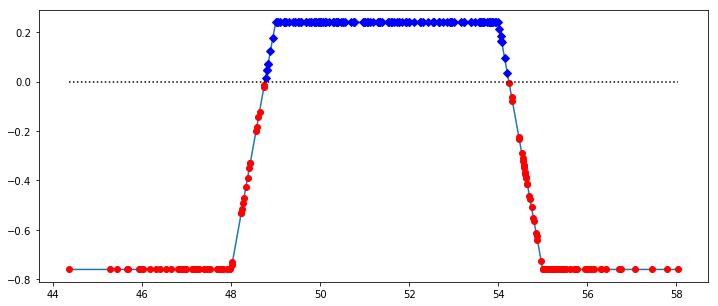

In [5]:
expiration = datetime.datetime(2018, 8, 18, 23, 59)
ohlc_symbol = ('XLU')
long_put = Option.PutPayout(expiration=expiration, 
                      strike=48.0, 
                      price=-0.16, 
                      positions=1)

short_put = Option.PutPayout(expiration=expiration, 
                      strike=49.0, 
                      price=0.24, 
                      positions=-1)

short_call = Option.CallPayout(expiration=expiration, 
                      strike=54.0, 
                      price=0.32, 
                      positions=-1)

long_call = Option.CallPayout(expiration=expiration, 
                      strike=55.0, 
                      price=-0.16, 
                      positions=1)

positions = [long_put, short_put, short_call, long_call]

# print (long_put.slope)
# print (long_put.offset)
# print (long_put.break_even)
# print ("\n")

# print (short_put.slope)
# print (short_put.offset)
# print (short_put.break_even)
# print ("\n")

# print (short_call.slope)
# print (short_call.offset)
# print (short_call.break_even)
# print ("\n")

# print (long_call.slope)
# print (long_call.offset)
# print (long_call.break_even)

XLU_Payouts = ExpirationPayout(ohlc_data).set_payouts(positions=positions, expiration=expiration)
XLU_Payouts.summary()

In [6]:
type(XLU_Payouts)

__main__.ExpirationPayout

## Want to know the following:
## 1) Expected loss using historical data
## 2) Expected payout using historical data

Getting the ohlc data from yahoo and calculate returns for the period between today till expiration

In [24]:
XLU_Payouts

In [ ]:
days_til_expiration = 0
current_date = datetime.datetime.today()
one_day = datetime.timedelta(days=1)
while current_date < expiration:
    if current_date.isoweekday() < 6:
        days_til_expiration += 1
    current_date += one_day

# calculate the new projected spots using past returns
# returns
spots = ohlc_data['Adj Close'] / ohlc_data['Adj Close'].shift(days_til_expiration)
# returns to spots
spots *= ohlc_data['Adj Close']
# some clean up
spots = spots[-252:]

payout_data = {
    'long_put': long_put.payout(spots),
    'short_put': short_put.payout(spots),
    'short_call': short_call.payout(spots),
    'long_call': long_call.payout(spots)
}
payouts = pd.DataFrame(data=payout_data).sum(axis=1)
payouts = pd.DataFrame(data=payouts.values, index =spots, columns=['Payout']).sort_index()
payouts.index.name = 'Spot'

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(payouts.index, payouts['Payout'])
itm_payouts = payouts[payouts.gt(0)]
plt.plot(itm_payouts.index, itm_payouts['Payout'], 'bD')
otm_payouts = payouts[payouts.lt(0)]
plt.plot(otm_payouts.index, otm_payouts['Payout'], 'ro')
plt.plot(payouts.index, np.repeat(0, payouts.size), 'k:')

In [ ]:
mean_positive_profit = payouts[payouts['Payout'].gt(0)].mean().values[0]
mean_negative_payout = payouts[payouts['Payout'].lt(0)].mean().values[0]
mean_payout = mean_positive_profit - mean_negative_payout
pop = payouts['Payout'].gt(0).sum() / payouts['Payout'].size

In [ ]:
print("Expected Payout: ${:.2f} with a P.O.P of {:.2%}".format((mean_payout*100), pop))
print("Expected Loss: ${:.2f} with a Probability of {:.2%}".format((mean_negative_payout*100), (1-pop)))

In [ ]:
mean_payout

In [ ]:
negative_payout = mean_negative_payout*100
positve_payout = mean_payout*100
worst_case = {'loss': np.repeat(negative_payout, 10),
              'payout': [positve_payout, positve_payout, positve_payout, positve_payout, positve_payout, 0, 0, 0, 0, 0]}
worst_case = pd.DataFrame(data=worst_case)

In [ ]:
print(worst_case)
print(worst_case.sum(axis=1))

In [ ]:
print(worst_case.sum(axis=1).mean())

In [ ]:
worst_case = pop*(positve_payout+negative_payout) + (1-pop)*(negative_payout)
worst_case

In [ ]:
# best_case/2 = (pop*postive_payout) +((1-pop)*min_negative_payout)
((best_case/2) - (pop*positve_payout)) / (1-pop)

In [ ]:
best_case = {'loss': np.repeat(negative_payout, 10),
              'payout': [positve_payout, positve_payout, positve_payout, positve_payout, positve_payout, -negative_payout, -negative_payout, -negative_payout, -negative_payout, -negative_payout]}
best_case = pd.DataFrame(data=best_case)

In [ ]:
print(best_case)
print(best_case.sum(axis=1))

In [ ]:
best_case.sum(axis=1).mean()

In [ ]:
best_case = pop*(positve_payout+negative_payout)
best_case

### Best and worst case percentages

In [ ]:
print("Worst case loss: {:.2%}".format(worst_case/negative_payout-1))
print("Best case gain: {:.2%}".format(best_case/-negative_payout))

In [ ]:
# target_case = pop*(positve_payout+negative_payout) + (1-pop)*(negative_lose)
target_case = best_case/2
negative_lose = (target_case - pop*(positve_payout+negative_payout)) / (1-pop)
negative_lose = -(-negative_lose + negative_payout)

In [ ]:
pop*(positve_payout+negative_payout) + (1-pop)*(negative_lose+negative_payout)

In [ ]:
negative_lose+negative_payout

In [ ]:
break_even_price = 44.812121000000005
break_even = {'loss': np.repeat(negative_payout, 10),
              'payout': [positve_payout, positve_payout, positve_payout, positve_payout, positve_payout, break_even_price, break_even_price, break_even_price, break_even_price, break_even_price]}
break_even = pd.DataFrame(data=break_even)

In [ ]:
break_even

In [ ]:
break_even.sum(axis=1)